# Koopman
## Qu'est-ce que Koopman ?
L’opérateur de Koopman est un cadre théorique issu de la théorie des systèmes dynamiques qui permet d’analyser un système non linéaire à l’aide d’un opérateur linéaire mais en agissant dans un espace de dimension plus élevée.
Considérons un système dynamique discret :
$$
z_{t+1}=f(z_{t})
$$
où $z_{t}$ représente l'état du système à l'instant t et f une dynamique potentiellement non linéaire.
L’idée clé de Koopman est de ne plus s’intéresser directement à l’évolution de l’état $z_{t}$ mais à l’évolution de fonctions observables de cet état. L’opérateur de Koopman K agit alors sur ces fonctions observables et est linéaire, même si la dynamique originale ne l’est pas.

Dans un cadre numérique et discret, cette idée se traduit par la recherche d’un opérateur linéaire A tel que :
$$
z_{t+1}≈Az_{t}
$$
où $z_{t}$ est un état réduit (par exemple obtenu par réduction de dimension ou projection sur une base de modes). Cette approximation est souvent obtenue par une méthode de type Dynamic Mode Decomposition (DMD), qui identifie l’opérateur A à partir de données temporelles.

L’intérêt fondamental de Koopman est donc de fournir une approximation linéaire globale de la dynamique, permettant une analyse spectrale (valeurs propres, modes dynamiques, stabilité) d’un système non linéaire.

## Pourquoi utiliser Koopman dans ce projet ?
L’objectif de ce projet n’est pas uniquement d’obtenir la meilleure précision de prédiction possible, mais de comprendre et structurer la dynamique du système dans un cadre compatible avec les approches SciML (Scientific Machine Learning).

Les modèles d’apprentissage automatique classiques (régression, réseaux de neurones, forêts aléatoires) sont très performants pour minimiser une erreur de prédiction à court terme, mais ils présentent plusieurs limites dans un contexte de systèmes dynamiques physiques :

- faible interprétabilité

- absence de garanties de stabilité à long terme

- difficulté à relier les résultats à une structure dynamique sous-jacente

L’opérateur de Koopman répond précisément à ces limitations :

- il fournit une dynamique globale unique valable sur tout l’espace d’apprentissage

- il permet une analyse spectrale (stabilité, modes dominants, échelles temporelles)

- il impose une structure dynamique cohérente, même si la précision locale est limitée

Dans une approche SciML, Koopman ne cherche donc pas à remplacer les modèles ML classiques, mais à servir de socle dynamique interprétable, sur lequel des corrections non linéaires peuvent éventuellement être ajoutées. Son faible nombre d’hyperparamètres et sa robustesse en font un outil particulièrement adapté à l’analyse exploratoire et à la modélisation structurée des systèmes physiques complexes.

In [ ]:
using NPZ
using LinearAlgebra

dataPath = "../../data/processed/sstReducedState2COPERNICUS20102019.npz" # essayer avec sstReducedState2COPERNICUS20102019.npz
data = npzread(dataPath)
# data contient le résultat final du prétraitement

rawZ = data["Z"] # (T, k) = (3652, 17)
rawdZ = data["dZ"] # (T, k) futur
time = data["time"] # (T,)
space = data["space"] # (k,)
split = data["split"] # (T,)

println("rawZ size : = ", size(rawZ))
println("time size : = ", size(time))
println("split size : = ", size(split))
println("space size : = ", size(space))

T, k = size(rawZ)
@assert length(time) == T
@assert length(split) == T
@assert length(space) == k

## Construction des jeux d'entraînements et de valeurs

In [ ]:
# Z en convention Koopman = (k, T)
completeZ = permutedims(rawZ) # transforme Z (T, k) en Z (k, T)
println("Taille de Z complet = ", size(completeZ))

# Séparation d'entraînements et de nos valeurs :
println("Valeurs uniques de split = ", unique(split))
# Puisque Split = 0 (train) et 1(val)
maskTrain = split .== 0
maskVal = split.== 1

trainZ = completeZ[:, maskTrain] # (k, Ttrain)
valZ = completeZ[:, maskVal] # (k, Tval)

tTrain = time[maskTrain]
tVal = time[maskVal]
println("trainZ taille = ", size(trainZ))
println("valZ taille = ", size(valZ))
println("tTrain taille = ", length(tTrain))
println("tVal taille = ", length(tVal))

## Création de nos matrices 

In [ ]:
z = trainZ[:, 1:end-1] # (k, T-1)
zP = trainZ[:, 2:end] # 

print("Z size : ", size(z))
print("Zp size : ", size(zP))

## Calcul de l'opérateur de Koopman

In [ ]:
zPseudoInv = pinv(z) # Pseudo Inverse de Z : (2921, 150)
A =zP * zPseudoInv

println("A size : ", size(A))

## Analyse de A

In [ ]:
spect = eigen(A) # décomposition spectrale
valPropres = spect.values # valeurs propres
vectPropres = spect.vectors # vecteurs propres

println("Nombre de valeurs propres = ", length(valPropres))

## Prédiction avec Koopman (baseline)


RMSE one step Koopman sur la validation = 0.4287795
RMSE multi step moyen sur la validation = 0.7657934

 Diagnostics rapides : 

 RMSE oneStep = 0.4287795

 RMSE multiStep moy = 0.7657934

 RMSE multiStep (5 premiers pas) = 
Float32[0.0, 1.5256636, 1.4518385, 1.4195274, 1.3727897]

 Mode EOF numéro 1 réel contre prédit (5 premiers temps) : 

 Réel = Float32[-0.92024505, 0.41394845, 0.5022059, 0.7051955, 0.6345787]

 Prédit = Float32[-0.92024505, -0.8277833, -0.7665781, -0.71763706, -0.6737109]


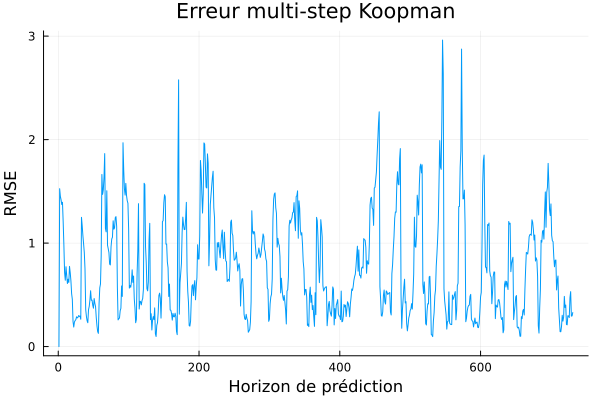

In [19]:
using Plots 
using Statistics

zValuesPresent = valZ[:, 1:end-1] # états en t
zValuesFuture = valZ[:, 2:end] # états en t+1

zValuesPredicted = A * zValuesPresent
error1Step = zValuesPredicted - zValuesFuture
rmse1Step = sqrt(mean(error1Step .^ 2))

println("\nRMSE one step Koopman sur la validation = ", rmse1Step)

# Multi step 

function koopmanRoll(A::AbstractMatrix, z0::AbstractVector, numberSteps::Int)
    tailleVect = length(z0)
    trajectoire = Matrix{eltype(A)}(undef, tailleVect, numberSteps + 1)
    trajectoire[:, 1] = z0
    z = copy(z0)
    for n in 1:numberSteps
        z = A * z 
        trajectoire[:, n+1] = z
    end 
    return trajectoire # (k, numberSteps + 1)
end 

# Evaluation sur toute notre période


z0Val = valZ[:, 1] # état initial
numberStepsVal = size(valZ, 2) - 1 # nombre de pas à prédire

trajectoirePredieVal = koopmanRoll(A, z0Val, numberStepsVal) # (k, tValues)

# Erreur à chaque instant
erreurTrajectoire = trajectoirePredieVal - valZ
# Vecteur de RMSE dans le temps
rmseTrajectoire = sqrt.(mean(erreurTrajectoire .^ 2; dims = 1))[:]

println("RMSE multi step moyen sur la validation = ", mean(rmseTrajectoire))

# Diagnostic

println("\n Diagnostics rapides : ")
println("\n RMSE oneStep = ", rmse1Step)
println("\n RMSE multiStep moy = ", mean(rmseTrajectoire))
### Affichage RMSE sur les 5 premiers pas de temps
println("\n RMSE multiStep (5 premiers pas) = ")
println(rmseTrajectoire[1:min(5, length(rmseTrajectoire))])

### Comparaison mode EOF (premier par exemple) réel contre prédiction sur les 5 premiers temps
modIndex = 1
println("\n Mode EOF numéro ", modIndex," réel contre prédit (5 premiers temps) : ")
println("\n Réel = ", valZ[modIndex, 1:min(5, size(valZ, 2))])
println("\n Prédit = ", trajectoirePredieVal[modIndex, 1:min(5, size(trajectoirePredieVal, 2))])

plot(
    rmseTrajectoire,
    xlabel="Horizon de prédiction",
    ylabel="RMSE",
    title="Erreur multi-step Koopman",
    legend=false
)

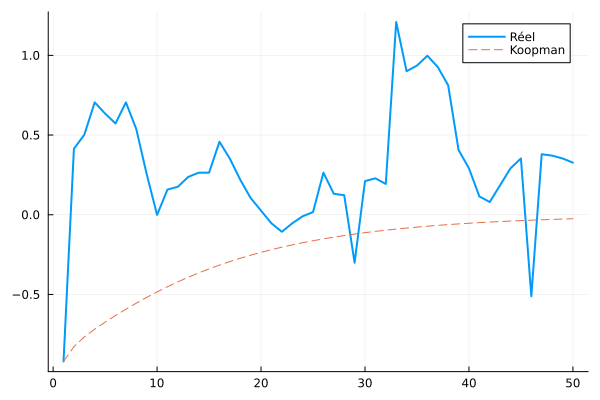

In [20]:
mode = 1
nShow = 50
plot(
    valZ[mode, 1:nShow],
    label="Réel",
    linewidth=2
)
plot!(
    trajectoirePredieVal[mode, 1:nShow],
    label="Koopman",
    linestyle=:dash
)


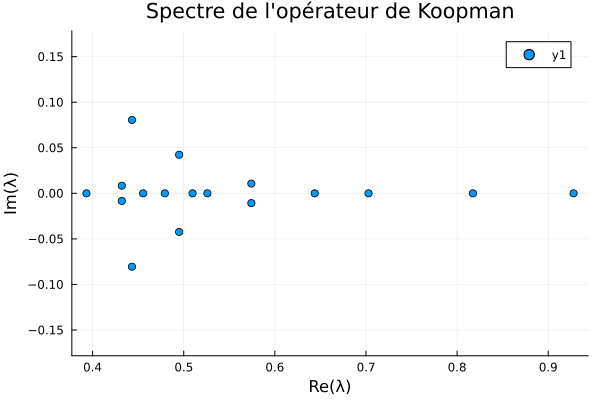

In [21]:
scatter(
    real.(valPropres), imag.(valPropres),
    xlabel="Re(λ)",
    ylabel="Im(λ)",
    title="Spectre de l'opérateur de Koopman",
    aspect_ratio=:equal
)

## Comment interpréter nos résultats ?
L’objectif de cette section est d’expliquer de manière intuitive ce que nous apprennent les résultats obtenus avec l’opérateur de Koopman, sans supposer de connaissances préalables en théorie des systèmes dynamiques.

### Comprendre les erreurs de prédiction

Nous commençons par analyser les erreurs de prédiction du modèle.
L’erreur one-step correspond à la capacité du modèle à prédire l’état suivant à partir de l’état courant, sur un seul pas de temps. Dans notre cas, cette erreur est relativement faible (RMSE ≈ 0.43), ce qui indique que le modèle reproduit correctement l’évolution immédiate du système.

L’erreur multi-step correspond à une situation plus exigeante : le modèle est utilisé de manière répétée pour prédire plusieurs pas de temps dans le futur, sans se recaler sur les données réelles. L’erreur augmente alors naturellement, mais reste bornée sur l’ensemble de l’horizon de prédiction (RMSE moyen ≈ 0.77). Cela signifie que, même lorsqu’on l’utilise sur le long terme, le modèle ne diverge pas et reste proche d’un comportement réaliste.

Pour un modèle linéaire appliqué à un système non linéaire, ce comportement est attendu et constitue un résultat positif : le modèle capture une dynamique globale stable, même s’il ne reproduit pas tous les détails fins.

### Ce que nous apprend l’analyse du spectre de Koopman

Le spectre de l’opérateur de Koopman correspond aux valeurs propres de la matrice A. Sans entrer dans les détails mathématiques, ces valeurs donnent des informations sur la stabilité et la nature de la dynamique.

Dans notre cas, toutes les valeurs propres sont situées à l’intérieur du cercle unité, ce qui signifie que les effets des perturbations ont tendance à s’atténuer avec le temps. Autrement dit, le modèle décrit un système stable, sans croissance non contrôlée des erreurs.

Certaines valeurs propres sont proches de 1, ce qui indique la présence de modes lents, c’est-à-dire de comportements qui évoluent lentement et persistent dans le temps. D’autres modes sont plus rapidement amortis. Cette structure est typique des systèmes physiques dissipatifs et confirme que l’opérateur de Koopman a capturé une organisation cohérente de la dynamique.

### Comparaison entre dynamique réelle et dynamique Koopman

La comparaison entre un mode réel et sa prédiction par Koopman permet de visualiser concrètement ce que fait le modèle. On observe que la prédiction Koopman suit une évolution lisse et régulière, qui représente bien la tendance globale du signal.

En revanche, les variations rapides et les changements brusques présents dans le signal réel ne sont pas reproduits fidèlement. Cela ne constitue pas une erreur du modèle, mais une conséquence directe de son hypothèse de base : Koopman cherche à représenter la dynamique par un opérateur linéaire unique, ce qui conduit naturellement à une description moyenne et lissée du comportement du système.

Cette observation est importante, car elle montre clairement la frontière entre ce que le modèle peut et ne peut pas représenter. Koopman capture la dynamique lente dominante, mais pas les non-linéarités locales responsables des fluctuations rapides.

### Conclusion 

Ces résultats montrent que le système étudié possède une structure dynamique globale suffisamment régulière pour être approximée par un opérateur linéaire stable. L’opérateur de Koopman fournit ainsi une description simple, robuste et interprétable de la dynamique principale du système.

Cependant, les écarts observés sur les transitions rapides indiquent que le système reste fondamentalement non linéaire. Cela justifie l’intérêt d’une approche SciML hybride, dans laquelle Koopman sert de base structurante pour la dynamique globale, tandis que des modèles plus flexibles peuvent être utilisés pour corriger localement les effets non linéaires.

En résumé, l’opérateur de Koopman ne cherche pas à reproduire chaque détail du signal, mais à mettre en évidence et exploiter la structure dynamique essentielle du système, ce qui en fait un outil pertinent et complémentaire aux méthodes d’apprentissage automatique classiques.